# Utilities

In [ ]:
# | default_exp util
import jax

jax.config.update("jax_enable_x64", True)

In [ ]:
# | export
import jax.numpy as jnp
from jax import vmap
from jaxtyping import Array, Float, Bool
import tensorflow_probability.substrates.jax as tfp
from tensorflow_probability.substrates.jax.distributions import (
    MultivariateNormalLinearOperator as MVNLO,
)

In [ ]:
import jax

In [ ]:
jax.config.update("jax_enable_x64", True)

## sampling from degenerate Multivariate normal

The `MultivariateNormalFullCovariance` distribution from `tfp` only supports non-singular covariance matrices for sampling, because internally a Cholesky decomposition is used, which is ambiguous for singular symmetric matrices. Instead, we use an eigenvalue decomposition, and compute a valid Cholesky root by QR-decomposition.

In [ ]:
# | export
LOFM = tfp.tf2jax.linalg.LinearOperatorFullMatrix
LOLT = tfp.tf2jax.linalg.LinearOperatorLowerTriangular


def degenerate_cholesky(Sigma):
    evals, evecs = jnp.linalg.eigh(Sigma)
    # transpose for QR
    # ensure positive eigenvalues
    sqrt_cov = jnp.einsum("...ij,...j->...ji", evecs, jnp.sqrt(jnp.abs(evals)))
    Q, R = jnp.linalg.qr(sqrt_cov, mode="complete")
    # ensure positive diagonal
    R = R * jnp.sign(jnp.einsum("...ii->...i", R)[..., None])
    L = R.swapaxes(-1, -2)
    return L


def MVN_degenerate(
    loc: Array, cov: Array
) -> tfp.distributions.MultivariateNormalLinearOperator:
    L = degenerate_cholesky(cov)
    return MVNLO(loc=loc, scale=LOLT(L))

In [ ]:
import jax.random as jrn
import matplotlib.pyplot as plt
import fastcore.test as fct

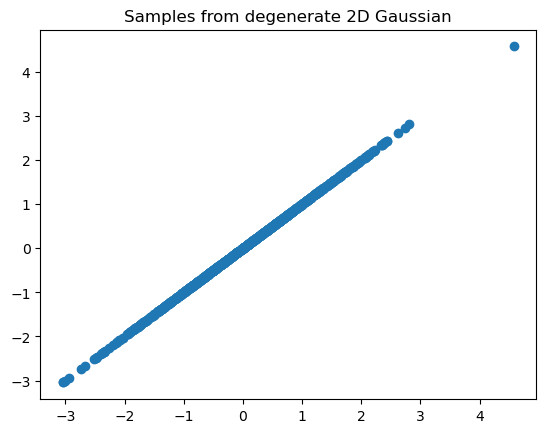

In [ ]:
mu = jnp.zeros(2)
Sigma = jnp.array([[1.0, 1.0], [1.0, 1.0]])

N = 1000
key = jrn.PRNGKey(1423423)
key, subkey = jrn.split(key)
samples = MVN_degenerate(mu, Sigma).sample(seed=subkey, sample_shape=(N,))
plt.title("Samples from degenerate 2D Gaussian")
plt.scatter(samples[:, 0], samples[:, 1])
plt.show()

fct.test_close(samples @ jnp.array([[1.0], [-1.0]]), jnp.zeros(N))

L = degenerate_cholesky(Sigma)
# ensure cholesky is correct
fct.test_close(Sigma, L @ L.T)
fct.test_ne(Sigma, L.T @ L)

## optimization

In [ ]:
# | export
def converged(
    new: Float[Array, "..."],  # the new array
    old: Float[Array, "..."],  # the old array
    eps: Float,  # tolerance
) -> Bool:  # whether the arrays are close enough
    """check that sup-norm of relative change is smaller than tolerance"""
    is_close = jnp.max(jnp.abs((new - old) / old)) < eps
    any_nans = jnp.isnan(new).sum() > 0
    return jnp.logical_or(is_close, any_nans)

## vmapped utilities

Throughout the package we make extensive use of matrix-vector multiplication. Depending on the algorithm, different vectorizations are helpful. 

Let $B \in \mathbf R^{(n+1)\times p \times m}$ be a list of $n + 1$ matrices, let $X \in \mathbf R^{(n + 1) \times m}$ be a set of states and let $\mathbf X \in \mathbf R^{N \times (n + 1) \times p}$ be $N$ simulations of $X$. 

`mm_sim` allows to multiply at a single time point $t$ the single matrix $B_t$ with all $X_t^i$, i.e, maps $$\mathbf R^{p \times m} \times \mathbf R^{N \times m} \to \mathbf R^{N \times p}.$$

`mm_time` allows to map the single sample $X$ for each time $t$ to $(B_tX_t)_{t = 0, \dots, n}$, i.e. maps $$\mathbf R^{(n +1) \times p \times m} \times \mathbf R^{(n + 1) \times m} \to \mathbf R^{(n+1) \times p}.$$

`mm_time_sim` allows to multiply all samples $\mathbf X$ ;or all times with matrices $B$, i.e. maps from $$\mathbf R^{(n + 1) \times p \times m}\times \mathbf R^{N \times (n+1) \times m} \to \mathbf R^{N \times (n + 1) \times p}.$$

In [ ]:
# | exports

# multiply $B_t$ and $X^i_t$
mm_sim = vmap(jnp.matmul, (None, 0))
# matmul with $(B_t)_{t}$ and $(X_t)_{t}$
mm_time = vmap(jnp.matmul, (0, 0))
# matmul with $(B_t)_{t}$ and $(X^i_t)_{i,t}$
mm_time_sim = vmap(mm_time, (None, 0))

In [ ]:
N, np1, p, m = 1000, 100, 3, 5
key, subkey = jrn.split(key)
B = jrn.normal(subkey, (np1, p, m))
key, subkey = jrn.split(key)
X = jrn.normal(subkey, (N, np1, m))

fct.test_eq(mm_sim(B[0], X[:, 0, :]).shape, (N, p))
fct.test_eq(mm_time(B, X[0]).shape, (np1, p))
fct.test_eq(mm_time_sim(B, X).shape, (N, np1, p))

## Appending to the front of an array

In [ ]:
# | export
def append_to_front(a0: Float[Array, "..."], a: Float[Array, "n ..."]):
    return jnp.concatenate([a0[None], a], axis=0)

## Antithetic variables

To improve the efficiency of importance sampling [@Durbin1997Monte] recommend using antithetic variables. These are a device to reduce Monte-Carlo variance by introducing negative correlations. We use both location- and scale-balanced antithetic variables.

In [ ]:
# | export
from tensorflow_probability.substrates.jax.distributions import Chi2


def location_antithetic(samples: Float[Array, "N ..."], mean: Float[Array, "N ..."]):
    return 2 * mean[None] - samples


def scale_antithethic(
    u: Float[Array, "N n+1 k"],
    samples: Float[Array, "N n+1 p"],
    mean: Float[Array, "n+1 p"],
):

    N, l = u.shape
    # ensure dtype is Float64
    chi_dist = Chi2(l * jnp.ones(1))

    c = jnp.linalg.norm(u, axis=1) ** 2
    c_prime = chi_dist.quantile(1.0 - chi_dist.cdf(c))

    return mean[None] + jnp.sqrt(c_prime / c)[:, None, None] * (samples - mean[None])

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()